# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix
import pyarrow

## Configurations

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Import Dataset

In [3]:
raw_df = pd.read_csv('weatherAUS.csv')
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Remove rows for which target column is empty

In [5]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

# Train, Validation, Test Split

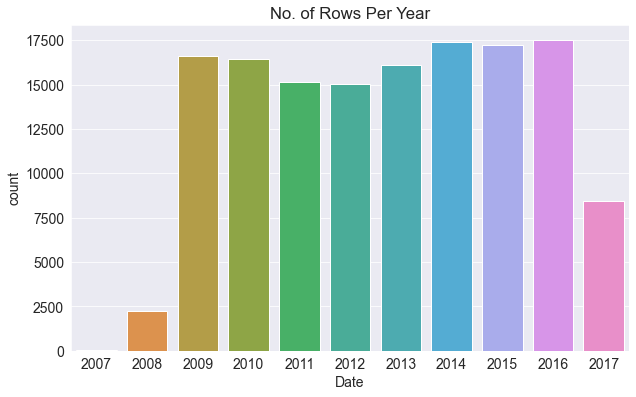

In [6]:
plt.title('No. of Rows Per Year');
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [7]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(98988, 23)
(17231, 23)
(25974, 23)


# Identify Inputs & Targets Columns

In [9]:
input_cols = list(train_df.columns[1:-1])
target_cols = train_df.columns[-1]

In [10]:
input_cols,target_cols

(['Location',
  'MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustDir',
  'WindGustSpeed',
  'WindDir9am',
  'WindDir3pm',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm',
  'RainToday'],
 'RainTomorrow')

# Identify Xs & Ys

In [11]:
X_train = train_df[input_cols].copy()
Y_train = train_df[target_cols].copy()
X_val = val_df[input_cols].copy()
Y_val = val_df[target_cols].copy()
X_test = test_df[input_cols].copy()
Y_test = test_df[target_cols].copy()

# Identify Numerical & Categorical Columns

In [12]:
numeric_cols = list(X_train.select_dtypes(include=np.number).columns)
categorical_cols = list(X_train.select_dtypes(include='object').columns)

In [13]:
numeric_cols, categorical_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

# Impute Missing Values

In [14]:
X_train[numeric_cols].isna().sum().sort_values(ascending=False)

Sunshine         40696
Evaporation      37110
Cloud3pm         36766
Cloud9am         35764
Pressure9am       9345
Pressure3pm       9309
WindGustSpeed     6902
Humidity9am       1265
Humidity3pm       1186
WindSpeed3pm      1140
WindSpeed9am      1133
Rainfall          1000
Temp9am            783
Temp3pm            663
MinTemp            434
MaxTemp            198
dtype: int64

In [15]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

In [16]:
X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
X_val[numeric_cols] = imputer.transform(X_val[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

In [17]:
X_train[numeric_cols].isna().sum().sort_values(ascending=False)

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

# Scaling Numeric Features

In [18]:
scaler = MinMaxScaler()
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

In [19]:
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Encoding Categorical Columns

In [20]:
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

***Note :***<br>
Fill Nans with 'Unknown' value in categorical columns

In [21]:
X_train[categorical_cols].isna().sum().sort_values(ascending=False)

WindDir9am     7323
WindGustDir    6943
WindDir3pm     2030
RainToday      1000
Location          0
dtype: int64

In [22]:
X_train[categorical_cols] = X_train[categorical_cols].fillna('Unknown')
X_val[categorical_cols] = X_val[categorical_cols].fillna('Unknown')
X_test[categorical_cols] = X_val[categorical_cols].fillna('Unknown')

In [23]:
X_train[categorical_cols].isna().sum().sort_values(ascending=False)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

In [24]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [25]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [26]:
encoded_cols

['Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Location_Perth',
 'Location_PerthAirport',
 'Location_Portland',
 'Location_Richmond',
 'Location_Sale',
 'Location_SalmonGums',
 'Location_Sydney',
 'Location_SydneyAirport',
 'Location_Townsville',
 'Location_Tuggeranong',
 'Location_Uluru',
 'Location_WaggaWagga',
 'Location_Walpole',
 'Locat

In [27]:
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

In [28]:
X_train = X_train[numeric_cols + encoded_cols]
X_val = X_val[numeric_cols + encoded_cols]
X_test = X_test[numeric_cols + encoded_cols]

# Training & Visualizing Decision Trees
A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="decision_trees.png" alt='decision trees' width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

## Training

In [29]:
model = DecisionTreeClassifier(random_state = 42)

In [30]:
%%time
model.fit(X_train, Y_train)

Wall time: 3.67 s


DecisionTreeClassifier(random_state=42)

## Evaluation

In [31]:
X_train_pred = model.predict(X_train)
X_train_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [32]:
pd.value_counts(X_train_pred)

No     76707
Yes    22281
dtype: int64

Seems prediction has more Nos.<br>
This is because the training set is also skewed

In [33]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [34]:
print('Training Accuracy :',accuracy_score(X_train_pred,Y_train)*100)

Training Accuracy : 99.99797955307714


The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [35]:
print('Validation Acuracy :',model.score(X_val,Y_val)*100)

Validation Acuracy : 79.28152747954267


In [36]:
Y_val.value_counts() / len(Y_val)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No", i.e,predicting always 'No' also gives around 78.8 % accuracy.<br>

This is because of overfitting.<br>
<b>Note :</b><br>
Decision Trees tends to overfit.

## Visualization
We'll visualize the decision tree learned from training data.

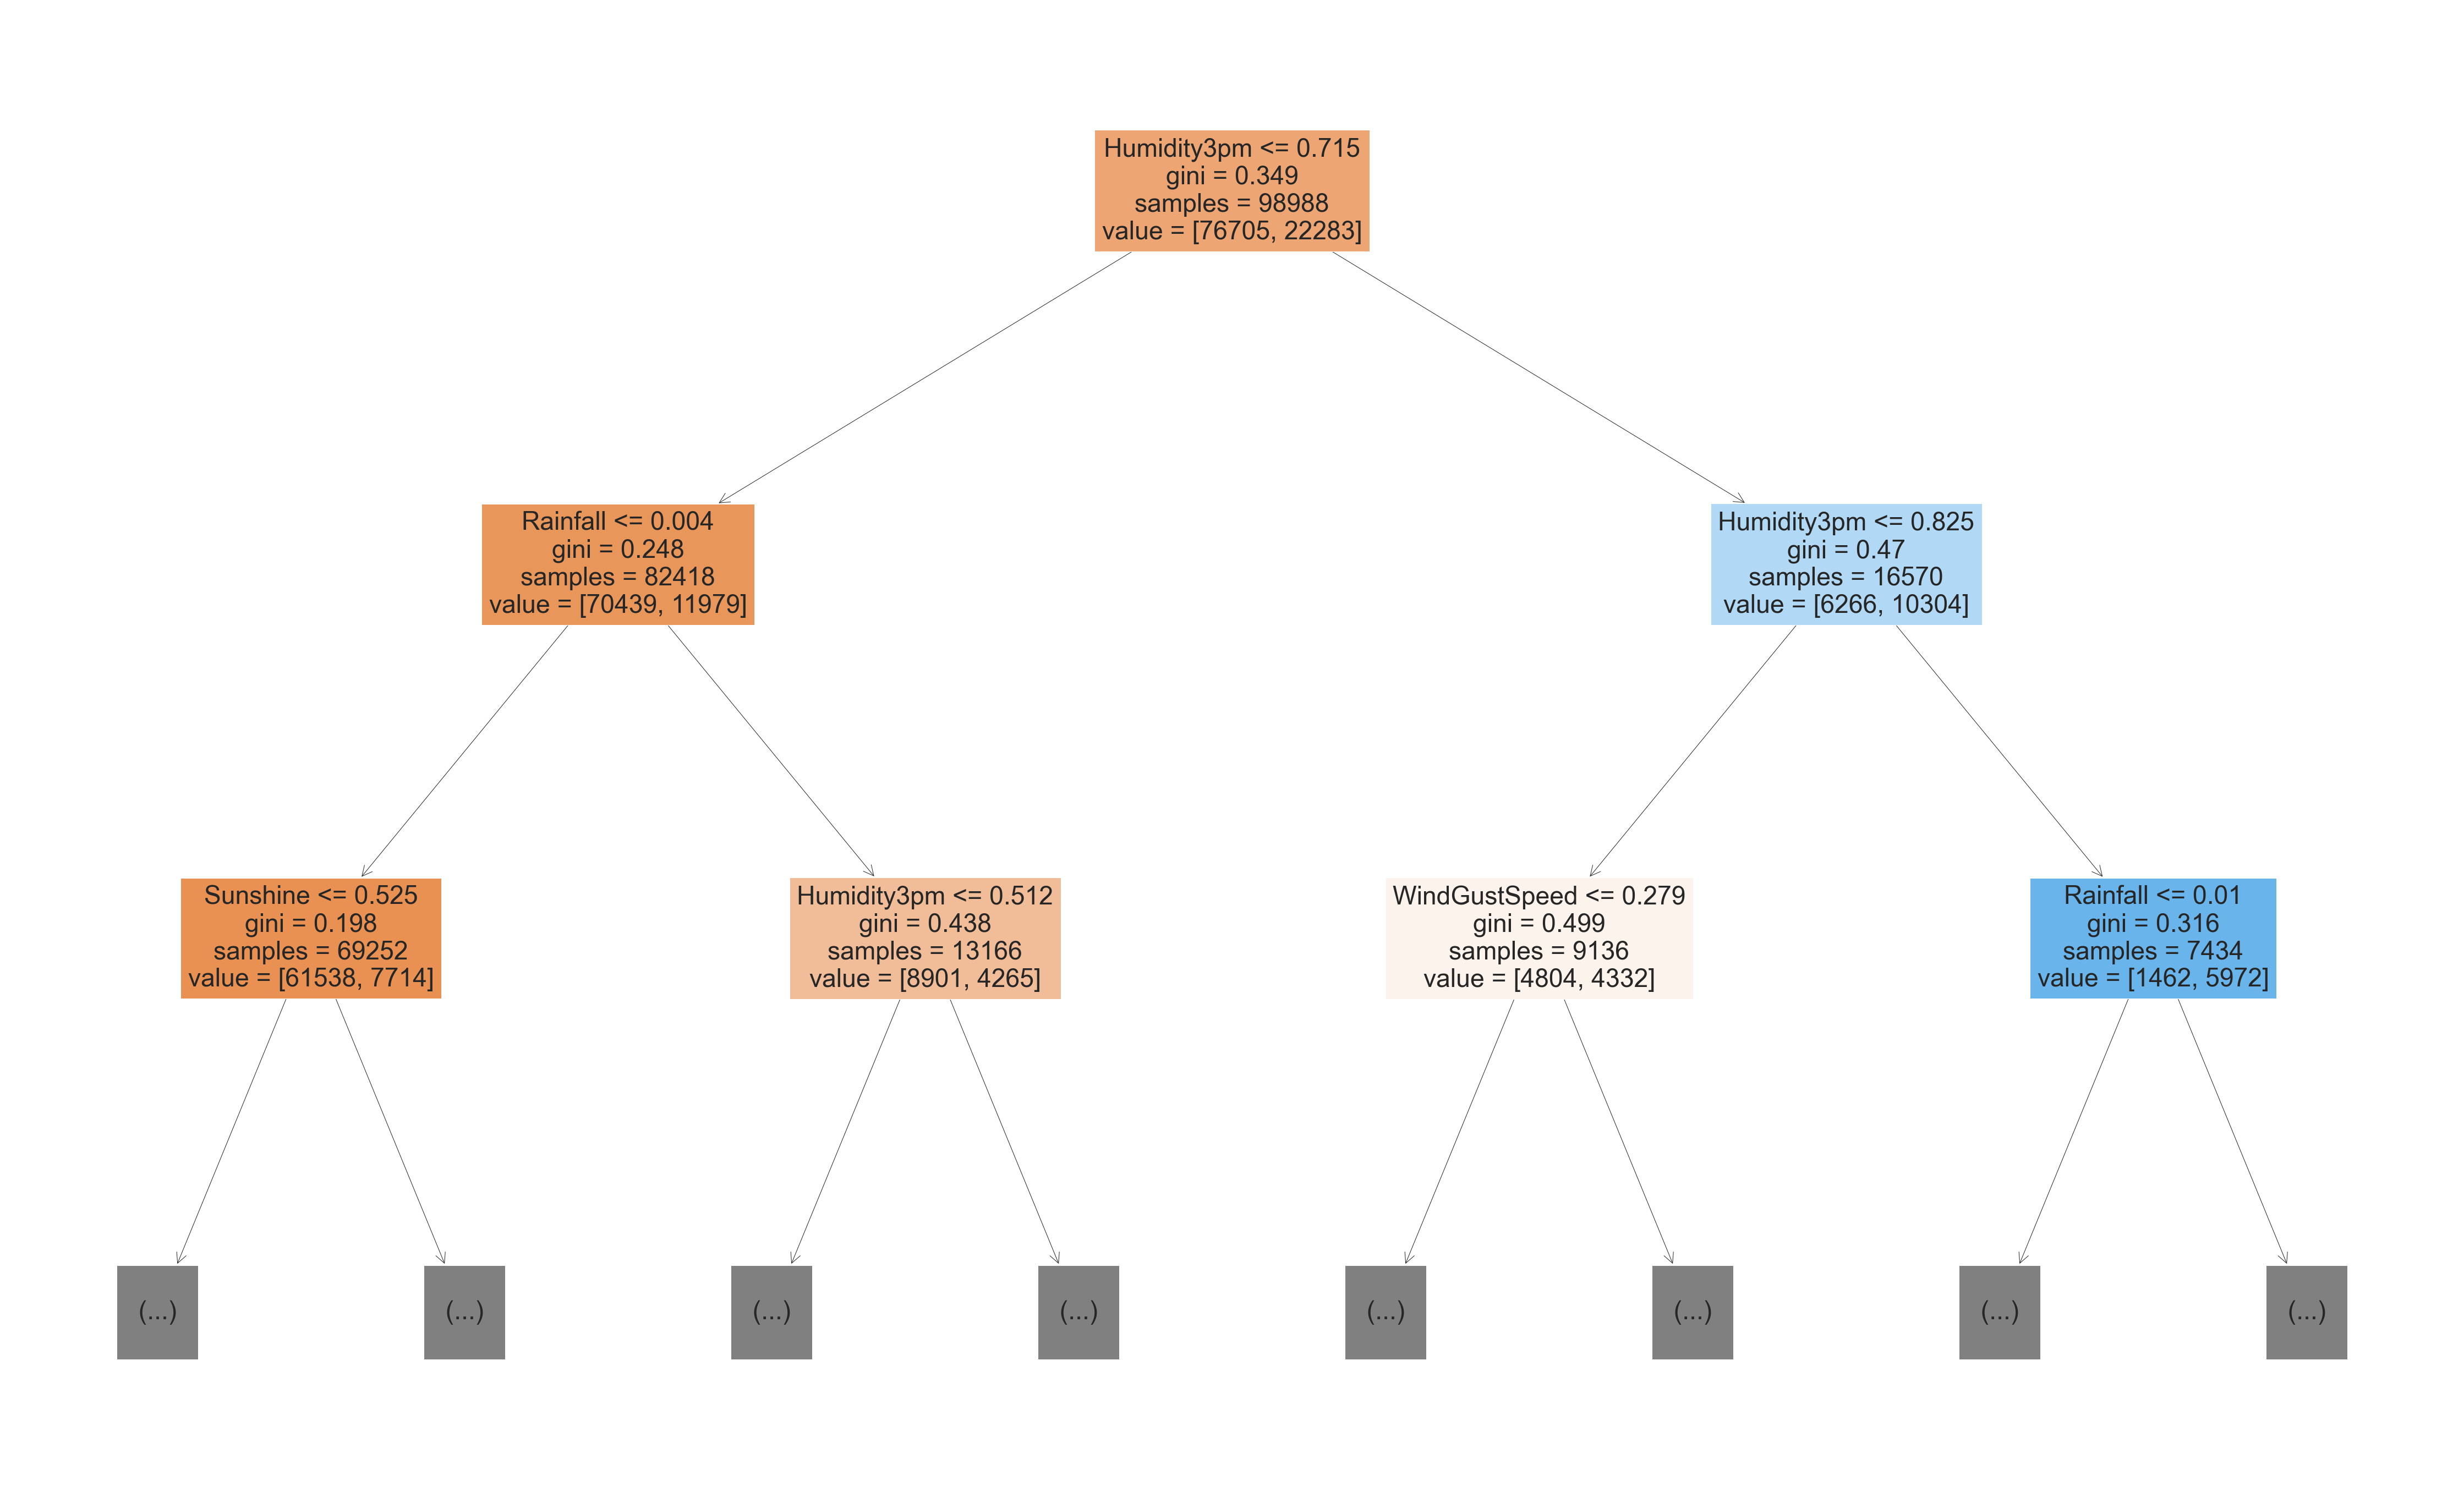

In [37]:
plt.figure(figsize=(80,50))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [38]:
model.tree_.max_depth

48

In [39]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am <= 0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am >  0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

# Feature Importance
Decision Trees can find iportance of features by itself.<br>
Below are thew importances of 119 features(total number of features in the training dataset)

In [40]:
model.feature_importances_

array([3.43949832e-02, 3.20723744e-02, 5.96978427e-02, 2.39997157e-02,
       4.96970278e-02, 5.52776844e-02, 2.77290154e-02, 2.87896517e-02,
       3.97762378e-02, 2.61665505e-01, 3.38797443e-02, 6.29086081e-02,
       1.41634157e-02, 1.82574107e-02, 3.39304134e-02, 2.99978180e-02,
       2.29983521e-03, 1.97127428e-03, 1.30448300e-03, 7.05458133e-04,
       1.51355792e-03, 1.12862805e-03, 8.66864394e-04, 1.77451768e-03,
       1.21677026e-03, 1.57331930e-03, 8.42954495e-04, 2.05031388e-03,
       1.90637772e-03, 3.26731137e-04, 1.11629763e-03, 1.52431517e-03,
       5.08479231e-04, 8.30004101e-04, 1.48248394e-03, 8.87667861e-04,
       7.61612213e-04, 7.02994607e-04, 1.72668316e-03, 2.07806756e-03,
       3.80229195e-04, 7.64016199e-04, 1.38715756e-03, 1.47491895e-03,
       1.48825382e-03, 8.67028594e-04, 8.33784178e-04, 1.54580309e-03,
       1.09367536e-03, 2.03218887e-03, 8.51581460e-04, 1.79979059e-03,
       9.69639078e-04, 1.28254100e-03, 1.28721925e-03, 3.77018000e-04,
      

In [41]:
feature_importance_df = pd.DataFrame({
    'Feature' : X_train.columns,
    'Importance' : model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
9,Humidity3pm,0.261666
11,Pressure3pm,0.062909
2,Rainfall,0.059698
5,WindGustSpeed,0.055278
4,Sunshine,0.049697
8,Humidity9am,0.039776
0,MinTemp,0.034395
14,Temp9am,0.033930
10,Pressure9am,0.033880
1,MaxTemp,0.032072


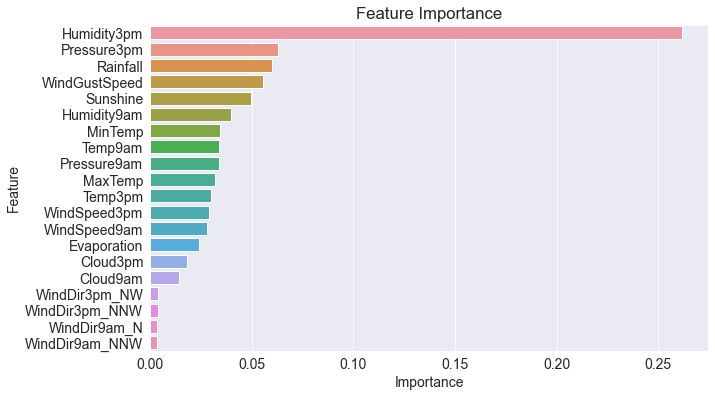

In [42]:
plt.title('Feature Importance')
sns.barplot(data = feature_importance_df.head(20), x='Importance', y='Feature');

# Hyperparameter Tuning To Reduce Overfitting

The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.<br>

- `max_depth`
- `max_leaf_nodes`

## max_depth
By reducing the tree maximum depth can reduce overfitting.<br>
Maximum depth (default) is 48 which is reduced to 3 to reduce overfittting as below.

In [43]:
model.tree_.max_depth

48

In [44]:
model = DecisionTreeClassifier(random_state=42, max_depth=3)

In [45]:
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [46]:
print('Accuracy in Training Dataset :',model.score(X_train, Y_train)*100)

Accuracy in Training Dataset : 82.91308037337859


In [47]:
print('Accuracy in Validation Dataset :',model.score(X_val, Y_val)*100)

Accuracy in Validation Dataset : 83.34397307178921


#### Visualisation

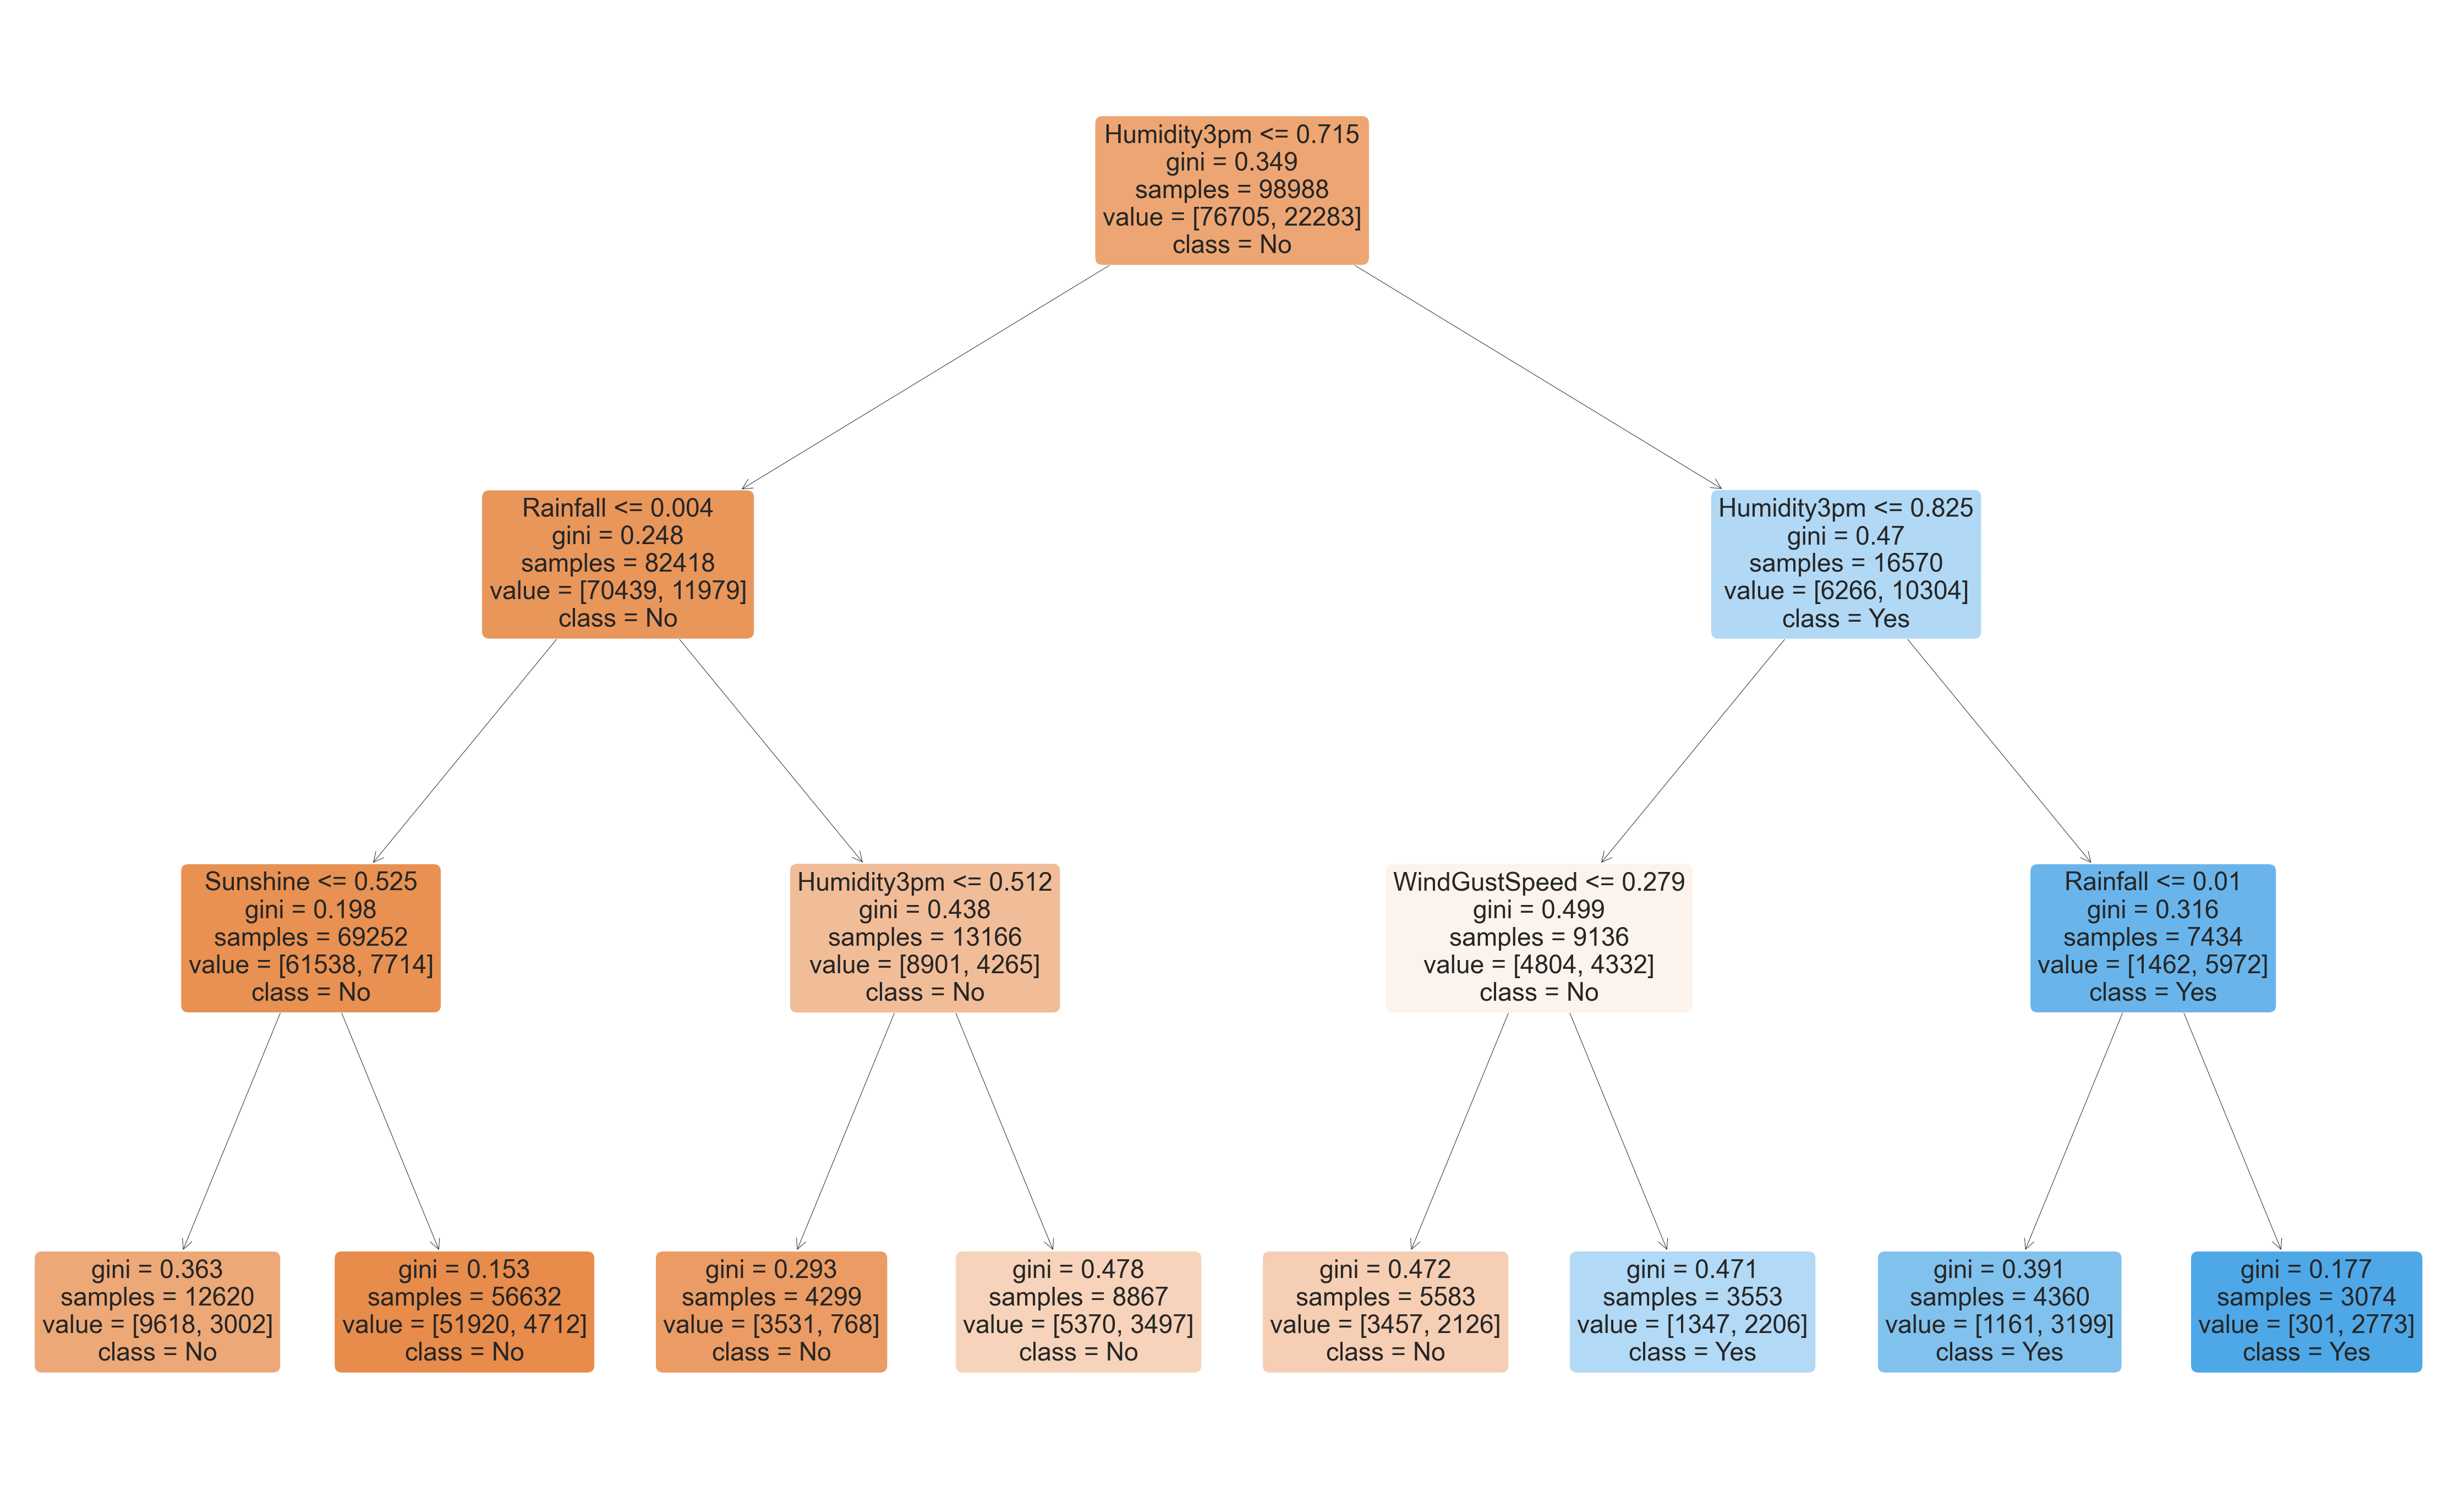

In [48]:
plt.figure(figsize=(80,50))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [49]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.52
|   |   |   |--- class: No
|   |--- Rainfall >  0.00
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- WindGustSpeed <= 0.28
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.28
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



### max_depth Tuning

Since the max_depth value without manual constraint for which our model overfitted is 48.<br>
And the max_depth value obviously can't be 0 (or lesser).<br>
So let's find what the best value of max_depth would be by trial and error method and use the max_depth for<br>
which the errors of train and validation dataset is optimal.

In [50]:
def max_depth_accuracy1(max_depth_val):
    model = DecisionTreeClassifier(random_state=42, max_depth=max_depth_val)
    model.fit(X_train, Y_train)
    train_accuracy = model.score(X_train, Y_train)*100
    val_accuracy = model.score(X_val, Y_val)*100
    return {'Max_Depth' : max_depth_val, 'Training_Accuracy' : train_accuracy, 'Validation_Accuracy' : val_accuracy}

In [51]:
%%time
accuracies_df1 = pd.DataFrame([max_depth_accuracy1(i) for i in range(1,48)])
accuracies_df1

Wall time: 2min 24s


,Max_Depth,Training_Accuracy,Validation_Accuracy
0,1,81.568473,82.206488
1,2,82.045298,82.728803
2,3,82.913080,83.343973
3,4,83.429305,83.564506
4,5,83.932396,84.092624
5,6,84.372853,84.272532
6,7,84.668849,84.539493
7,8,85.219421,84.226104
8,9,85.908393,84.342174
9,10,86.703439,84.243515


#### Save accuracies_df1 dataframe

In [52]:
accuracies_df1.to_parquet('Accuracies_max_depth_tuning1.parquet')

#### Load saved accuracies_df1

In [53]:
accuracies_df1 = pd.read_parquet('Accuracies_max_depth_tuning1.parquet')

In [54]:
accuracies_df1

,Max_Depth,Training_Accuracy,Validation_Accuracy
0,1,81.568473,82.206488
1,2,82.045298,82.728803
2,3,82.913080,83.343973
3,4,83.429305,83.564506
4,5,83.932396,84.092624
5,6,84.372853,84.272532
6,7,84.668849,84.539493
7,8,85.219421,84.226104
8,9,85.908393,84.342174
9,10,86.703439,84.243515


From the dataframe, it can be seen that the training accuracy increases with increase in max_depth.<br>
It is also to be noted that validation accuracy first increases and then decreases.<br>

##### Plotting Tuning Graph
Let'us visualise the training accuracy and validation accuracy with different max_depths.<br>

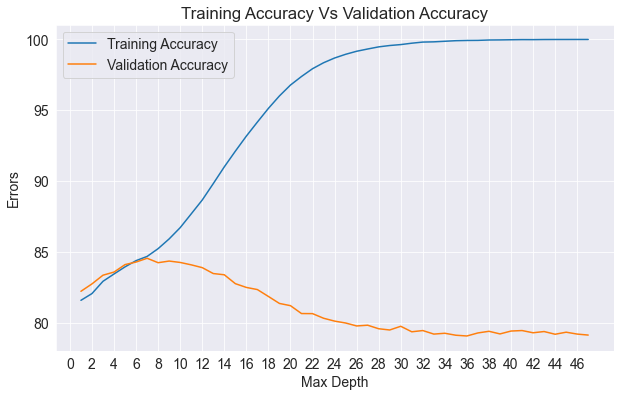

In [55]:
plt.title('Training Accuracy Vs Validation Accuracy');
plt.plot(accuracies_df1['Max_Depth'], accuracies_df1['Training_Accuracy']);
plt.plot(accuracies_df1['Max_Depth'], accuracies_df1['Validation_Accuracy']);
plt.legend(['Training Accuracy', 'Validation Accuracy']);
plt.xticks(range(0,48, 2))
plt.xlabel('Max Depth');
plt.ylabel('Errors');

From the graph it can also be seen that training accuracy increases with increase in max_depth<br>
while validation accuracy first increases (till max_depth = 7) and then decreases.<br>
Therefore, optimal max_depth is 7.

#### Buiild Decision Tree with max_depth = 7

In [56]:
model = DecisionTreeClassifier(random_state=42, max_depth=7)
model.fit(X_train, Y_train)
print('Training Accuracy :', model.score(X_train,Y_train)*100)
print('Validation Accuracy :', model.score(X_val, Y_val)*100)

Training Accuracy : 84.66884874934335
Validation Accuracy : 84.53949277465034


## max_leaf_nodes
Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [57]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model.fit(X_train, Y_train)
print('Training Accuracy :', model.score(X_train,Y_train)*100)
print('Validation Accuracy :', model.score(X_val, Y_val)*100)

Training Accuracy : 84.80421869317493
Validation Accuracy : 84.42342290058616


In [58]:
model.tree_.max_depth

12

Let's see the accuracies when max_depth was set to 12 while tuning max_depth parameter.<br>
They are not same because number of nodes in that case might be different.

In [59]:
accuracies_df1.loc[accuracies_df1['Max_Depth'] == model.tree_.max_depth]

,Max_Depth,Training_Accuracy,Validation_Accuracy
11,12,88.655191,83.877894


In [60]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

In [61]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42, max_depth=6)

In [62]:
def max_depth_accuracy2(max_depth_val):
    model = DecisionTreeClassifier(random_state=42, max_depth=max_depth_val, max_leaf_nodes=128)
    model.fit(X_train, Y_train)
    train_accuracy = model.score(X_train, Y_train)*100
    val_accuracy = model.score(X_val, Y_val)*100
    return {'Max_Depth' : max_depth_val, 'Training_Accuracy' : train_accuracy, 'Validation_Accuracy' : val_accuracy}

In [63]:
%%time
accuracies_df2 = pd.DataFrame([max_depth_accuracy2(i) for i in range(1,14)])
accuracies_df2

Wall time: 18.8 s


,Max_Depth,Training_Accuracy,Validation_Accuracy
0,1,81.568473,82.206488
1,2,82.045298,82.728803
2,3,82.913080,83.343973
3,4,83.429305,83.564506
4,5,83.932396,84.092624
5,6,84.372853,84.272532
6,7,84.668849,84.539493
7,8,84.904231,84.382798
8,9,84.896149,84.464047
9,10,84.810280,84.464047


#### Save accuracies_df2 dataframe

In [64]:
accuracies_df2.to_parquet('Accuracies_max_depth_tuning2.parquet')

#### Load saved accuracies_df2

In [65]:
accuracies_df2 = pd.read_parquet('Accuracies_max_depth_tuning2.parquet')

##### Plotting Tuning Graph
Let'us visualise the training accuracy and validation accuracy with different max_depths and max_leaf_nodes = 128.<br>

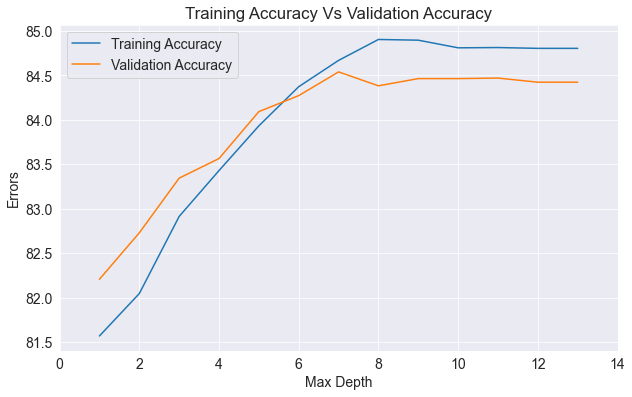

In [66]:
plt.title('Training Accuracy Vs Validation Accuracy');
plt.plot(accuracies_df2['Max_Depth'], accuracies_df2['Training_Accuracy']);
plt.plot(accuracies_df2['Max_Depth'], accuracies_df2['Validation_Accuracy']);
plt.legend(['Training Accuracy', 'Validation Accuracy']);
plt.xticks(range(0,16, 2))
plt.xlabel('Max Depth');
plt.ylabel('Errors');

It seems max_depth = 9 and max_leaf_nodes = 128 is the optimal hyperparameters

In [67]:
model = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=128, random_state=42)
model.fit(X_train, Y_train)
print('Training Accuracy :', model.score(X_train,Y_train)*100)
print('Validation Accuracy :', model.score(X_val, Y_val)*100)

Training Accuracy : 84.89614902816504
Validation Accuracy : 84.46404735650862
